<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/FINAL%20_FILES/Fashion_MNIST_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import and pre-process the data, train the CVAE

**Import libraries used and mount a google drive**

In [95]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
tf.autograph.set_verbosity(0)
tf.executing_eagerly()

True

**Function to plot images**

Takes images and labels datasets and plots certain images from it 

In [0]:
def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

**Create a dataset from images**

pick_class = selects all the data of certain classes

set_pixels_binary = scales the input values within 0 and 1

cut_data = selects a certain amount of data only

In [0]:
def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

def set_pixels_binary(images):
    images = images/input_range
    return images

def make_categorical(y, n):
    y_cat = tf.keras.utils.to_categorical(y, num_classes=n)
    return y_cat

def resort_classes(y):
    new_y = np.zeros(np.shape(y))
    classes = np.unique(y)
    for i in range(len(y)):
        for j in range(len(classes)):
            if y[i]==classes[j]:
                new_y[i]=j
    return new_y

def cut_data(data, data_number):
    data = data[0:data_number]
    return data

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
    x_train, y_train = pick_class(x_train, y_train, chosen_classes)
    x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
    x_train = cut_data(x_train, data_number)
    y_train = cut_data(y_train, data_number)

    train_images = set_pixels_binary(x_train)
    test_images = set_pixels_binary(x_test)

    train_images = train_images.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    test_images = test_images.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

    reclassed_y_train = resort_classes(y_train)
    reclassed_y_test = resort_classes(y_test)

    train_labels = make_categorical(reclassed_y_train, len(chosen_classes))
    test_labels = make_categorical(reclassed_y_test, len(chosen_classes))

    batch_size = 100
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(len(y_train)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(len(y_test)).batch(batch_size)
    
    return x_train, y_train, x_test, y_test, train_dataset, test_dataset

**Class of the Variational Autoencoder Models (two different models given, choose one)**

encode = takes an image and returns the mean and the log(variance) of its latent vector 

reparameterize = takes the mean and log(variance) of a latent vector and samples a vector from them

decode = takes a latent vector and returns the reconstruction of x

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.enc1 = tf.keras.layers.Flatten(input_shape=(28, 28, 1))
        self.enc2 = tf.keras.layers.concatenate
        self.enc3 = tf.keras.layers.Dense(512, activation='relu')
        self.enc4 = tf.keras.layers.Dense(z_size*2)

        self.dec1 = tf.keras.layers.concatenate
        self.dec2 = tf.keras.layers.Dense(units=512, activation='relu', input_shape=(z_size+n_classes,))
        self.dec3 = tf.keras.layers.Dense(784)
        self.dec4 = tf.keras.layers.Reshape(target_shape=(28, 28, 1))

    def encode(self, x, y):
        x = self.enc1(x)
        x = self.enc2([x, y], axis=1)
        x = self.enc3(x)
        x = self.enc4(x)
        encoder_nn_output = x
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled   

    def decode(self, z, y):
        z = self.dec1([z, y], axis=1)
        z = self.dec2(z)
        z = self.dec3(z)
        z = self.dec4(z)
        pixel_output = z
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

**Function to compute the ELBO loss**

Takes an image and returns the ELBO loss. The term variance is a hyperparameter and can be changed

In [0]:
def calculate_ELBO(model, x, y):
    z_mean, z_logvar = model.encode(x, y)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z, y)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO #Negative because we want to maximise it

**Define optimizer and loss metrics**

The learnign rate of the Adam optimizer is a hyperparameter

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

**Define a function for a train and test step**

train_step = updated the model using the optimizer and the gradients of the loss function; updates the train_loss metric

test_step = calculates the loss function of the test image; updates the test_loss metric

In [0]:
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, y, optimizer):
    loss = calculate_ELBO(model, x, y)
    test_loss(loss)

**Write function to train the dataset**

takes train and test datasets and trains the train dataset for a number of epochs

plots the ELBO value of the train and test dataset for each epoch

generates images obtained from a random latent vector (sampled form a normal distribution)

In [0]:
def generate_images(model, z_random, y, figures_to_plot):
    generated_prob = model.decode(z_random, y)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = n_classes
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  y_generate = np.eye(n_classes)

  test_ELBO = []
  train_ELBO = []
  epoch_number = []
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x, train_y in train_dataset: 
      train_step(model, train_x, train_y, optimizer)
  
    for test_x, test_y in test_dataset:
      test_step(model, test_x, test_y, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, y_generate, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

**Change the amount of data from each class (if desired)**

In [0]:
def change_ratio(x, y, chosen_classes, chosen_numbers):
    x_new = np.zeros([0,image_shape[0], image_shape[1]])
    y_new = np.zeros([0])
    n_classes = len(chosen_classes)
    for i in range (n_classes):
        x_class, y_class = pick_class(x, y, [chosen_classes[i]])
        x_class = cut_data(x_class, chosen_numbers[i])
        y_class = cut_data(y_class, chosen_numbers[i])
        x_new = np.concatenate((x_new, x_class))
        y_new = np.concatenate((y_new, y_class))
    return x_new, y_new

In [0]:
mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)
chosen_classes=[0,1,2,3,4,5,6,7,8,9]
n_classes = len(chosen_classes)
chosen_numbers = [5, 10, 50, 100, 500, 1000, 2000, 3000, 4500, 6000]
x_train, y_train = change_ratio(x_train, y_train, chosen_classes, chosen_numbers)
chosen_numbers = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
x_test, y_test = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

**Train the CVAE**


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



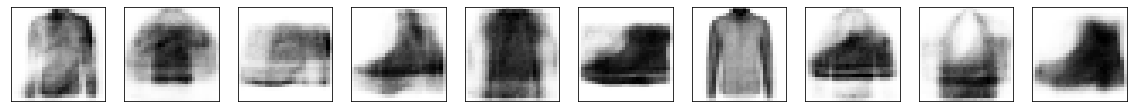

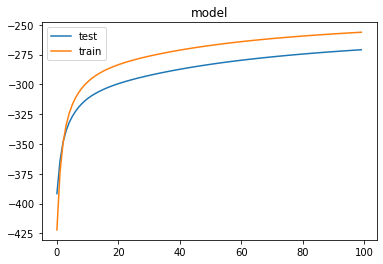

Remember that the classes represent the following original classes:
class:0 is 0
class:1 is 1
class:2 is 2
class:3 is 3
class:4 is 4
class:5 is 5
class:6 is 6
class:7 is 7
class:8 is 8
class:9 is 9


In [106]:
x_train, y_train, x_test, y_test, train_dataset, test_dataset = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=chosen_classes, data_number=-1)
reclassed_y_train = resort_classes(y_train)
reclassed_y_test = resort_classes(y_test)
train_labels = make_categorical(reclassed_y_train, n_classes)
test_labels = make_categorical(reclassed_y_test, n_classes)

z_size = 100
model = CVAE(z_size)
train_test_dataset(model, train_dataset, test_dataset, 200, generate=True)

print('Remember that the classes represent the following original classes:')
classes = np.unique(y_train)
for i in range(len(classes)):
    print('class:{} is {}'.format(i,int(classes[i])))

**Check reconstruction performance**

Select a range of image to reconstruct, the ELBO loss is displayed under each reconstruction

Original Pictures:


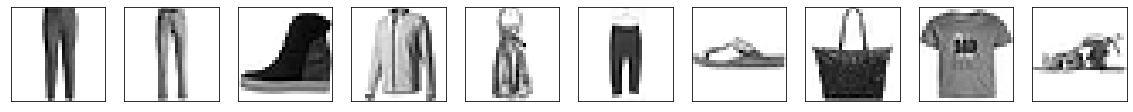

Reconstructed Pictures, with ELBO loss:


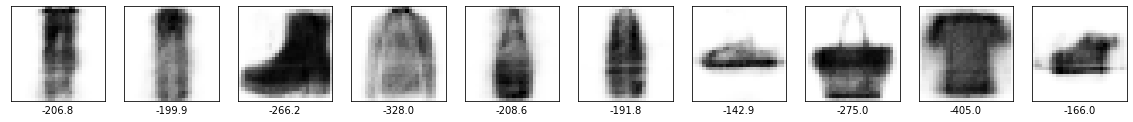

In [109]:
import sklearn.utils

def reconstruct_images(model, images, labels):
    images_n = len(images)
    x = images/input_range
    x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    reclassed_labels = resort_classes(labels)
    y = make_categorical(reclassed_labels, n_classes)
    
    z_mean, z_logvar = model.encode(x, y)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z, y)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = calculate_ELBO(model,x[i:i+1], y[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images, _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)
    
x_test_shuffled, y_test_shuffled = sklearn.utils.shuffle(x_test, y_test)
reconstruct_images(model, x_test_shuffled[20:30], y_test_shuffled[20:30])

**Visualize the latent space**

select a range (range1 to range2) of the train/test data for which to plot the latent vector values of 2 dimensions (a and b)

0 Outliers detected


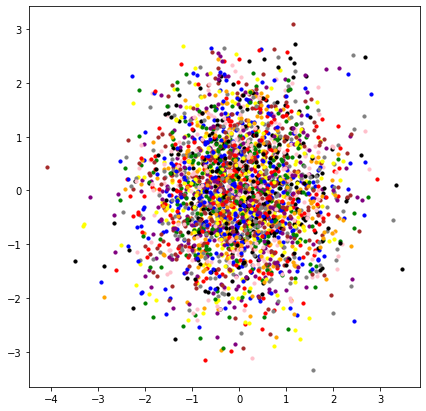

In [112]:
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize/input_range
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    label_visualize = data_y[i]
    label_visualize = label_visualize.reshape(1, len(label_visualize))
    
    z_mean, z_logvar = model.encode(pic_visualize, label_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    num=np.argmax(label_visualize)

    if num == 0:
      color = 'blue'
    if num == 1:
      color = 'orange'
    if num == 2:
      color = 'green'
    if num == 3:
      color = 'red'
    if num == 4:
      color = 'purple'  
    if num == 5:
      color = 'brown'
    if num == 6:
      color = 'pink'
    if num == 7:
      color = 'gray'
    if num == 8:
      color = 'black'
    if num == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
  print('{} Outliers detected'.format(outliers))

x_test_shuffled, test_labels_shuffled = sklearn.utils.shuffle(x_test, test_labels)
visualize_latent_space(model, 0,3000, x_test_shuffled, test_labels_shuffled, 0,1)

**Generate data**


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



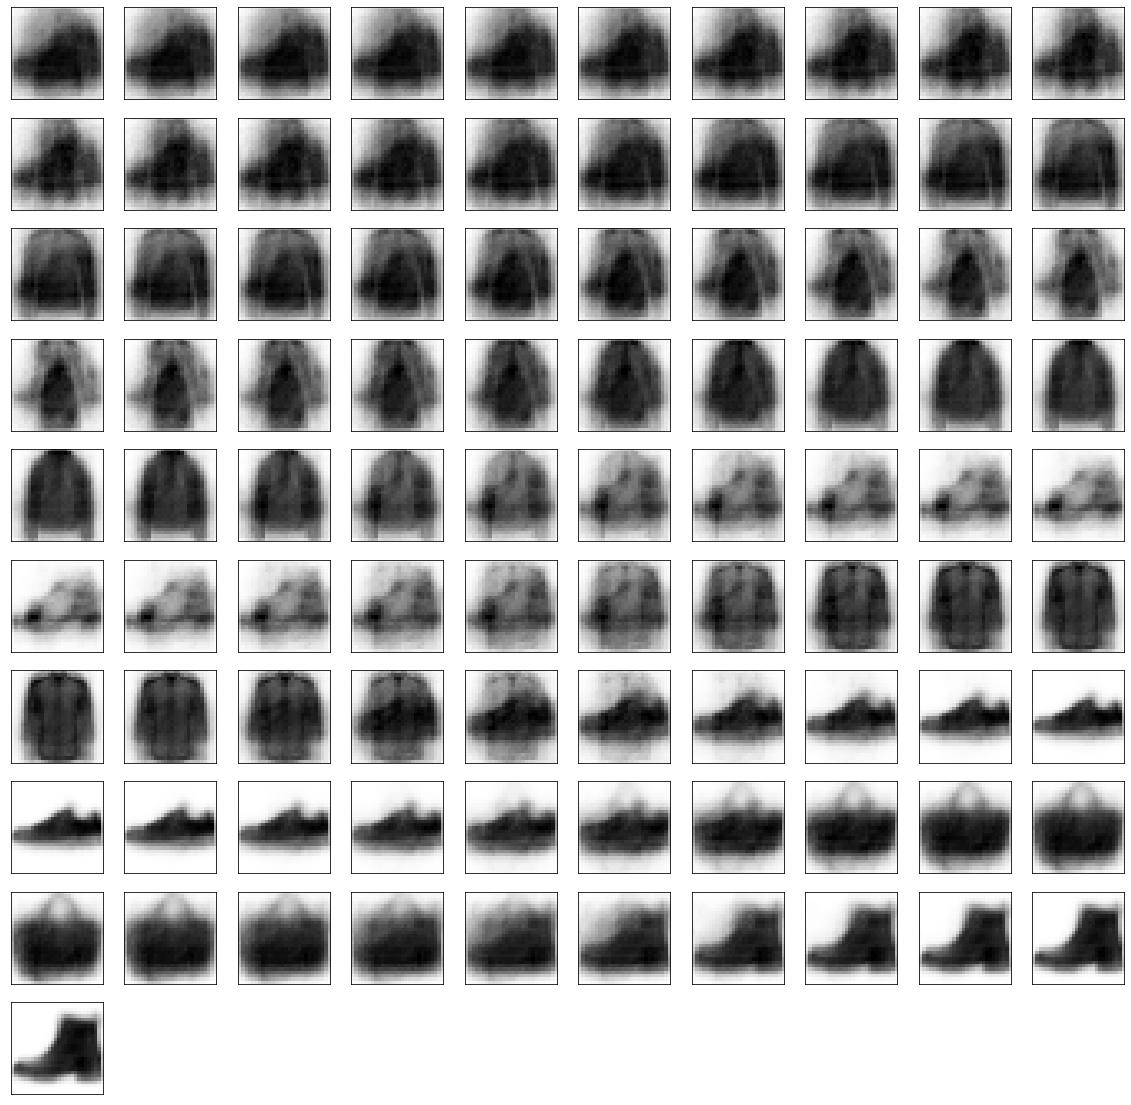

In [113]:
z_random = tf.random.normal(shape=[1, z_size])
manual_z = np.ones([1,z_size])*0
rows = ((n_classes)-1)*10
y_generate = np.zeros((rows+1, n_classes+z_size))
for i in range(rows):
  m = i // 10
  r = i % 10
  y_generate[i, m+z_size] = 1 - r*0.1
  y_generate[i, m + z_size+1]= r *0.1
y_generate[-1,-1]=1
y_generate[:,:z_size] = manual_z
generate_images(model, y_generate[:,:z_size], y_generate[:,z_size:], [0,rows+1])

#### Classify test images

**Classify images as the one with the lowest loss**

In [114]:
images = x_test
predicted_class = np.zeros([1,len(images)])
images_n = len(images)
x = images/input_range
x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
loss = np.empty([images_n, n_classes])

for j in range(n_classes):
  print('Testing all test images with class input (y={})'.format(j))
  ytest = np.ones([len(images),])*j
  y = make_categorical(ytest, n_classes)
  for i in range(images_n):
      loss[i,j] = calculate_ELBO(model,x[i:i+1], y[i:i+1])

for i in range(images_n):
  predicted_class[0,i] = np.argmin(loss[i,:])

Tested all test images with class input (y=0)
Tested all test images with class input (y=1)
Tested all test images with class input (y=2)
Tested all test images with class input (y=3)
Tested all test images with class input (y=4)
Tested all test images with class input (y=5)
Tested all test images with class input (y=6)
Tested all test images with class input (y=7)
Tested all test images with class input (y=8)
Tested all test images with class input (y=9)


**Check accuracy results**

In [115]:
import pandas as pd
predicted_class = predicted_class.astype('int')
reclassed_y_test = reclassed_y_test.astype('int')

wrong_guesses = []
table_of_counts = np.zeros([n_classes, n_classes+1])
for i in range(predicted_class.shape[1]):
    table_of_counts[reclassed_y_test[i], predicted_class[0,i]]+=1
    if reclassed_y_test[i] != predicted_class[0,i]:
        wrong_guesses.append(i)
trace_count = table_of_counts.trace().astype('int')
sum_count = table_of_counts.sum().astype('int')
for i in range(n_classes):
    accuracy_of_class = 100*table_of_counts[i,i]/np.sum(table_of_counts[i,0:-1])
    table_of_counts[i,-1] = accuracy_of_class.astype('float16')

index = list(str('-') * n_classes)
columns = list(str('-') * (n_classes+1))
for i in range(n_classes):
    index[i]= 'Class '+ str(i)
    columns[i] = '|' + str(i) + '_Counts|'
columns[-1] = 'Percentage'
table = pd.DataFrame.from_records(table_of_counts, index=index, columns=columns)

print('Correctly labelled pictures:{}/{} -> Accuracy: {}%'.format(trace_count, sum_count, trace_count/sum_count*100))
print('Incorrectly labelled pictures:{}/{} -> Error: {}%'.format(sum_count-trace_count, sum_count, (sum_count-trace_count)/sum_count*100))
table

Correctly labelled pictures:5474/10000 -> Accuracy: 54.74%
Incorrectly labelled pictures:4526/10000 -> Error: 45.26%


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,145.0,42.0,88.0,103.0,61.0,7.0,520.0,0.0,34.0,0.0,14.500000
Class 1,50.0,598.0,41.0,230.0,37.0,0.0,39.0,0.0,4.0,1.0,59.812500
Class 2,73.0,40.0,208.0,73.0,237.0,2.0,340.0,0.0,27.0,0.0,20.796875
Class 3,109.0,73.0,84.0,522.0,60.0,8.0,132.0,0.0,12.0,0.0,52.187500
Class 4,63.0,48.0,113.0,47.0,497.0,5.0,204.0,0.0,23.0,0.0,49.687500
Class 5,35.0,23.0,17.0,25.0,11.0,736.0,7.0,93.0,4.0,49.0,73.625000
Class 6,93.0,35.0,128.0,66.0,157.0,5.0,480.0,0.0,35.0,1.0,48.000000
Class 7,39.0,34.0,18.0,10.0,12.0,41.0,2.0,779.0,1.0,64.0,77.875000
Class 8,55.0,28.0,77.0,40.0,51.0,10.0,55.0,3.0,680.0,1.0,68.000000
Class 9,27.0,34.0,14.0,10.0,10.0,21.0,1.0,53.0,1.0,829.0,82.875000


**Check reconstruction performance**

Check the average loss the models obtain for each class

Create confusion matrix table with all the losses

Pictures tested assuming a class 0


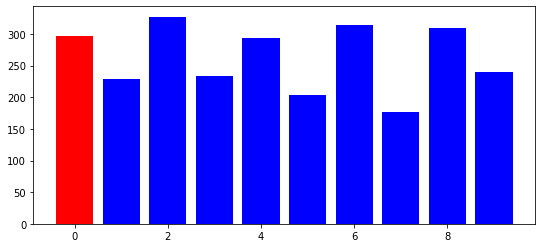

Pictures tested assuming a class 1


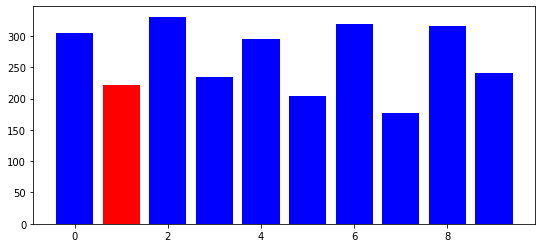

Pictures tested assuming a class 2


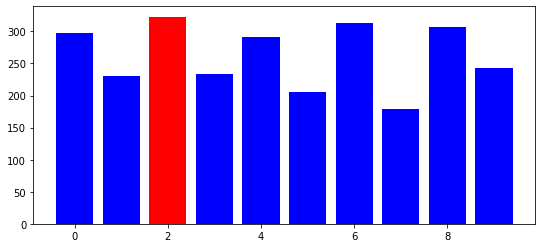

Pictures tested assuming a class 3


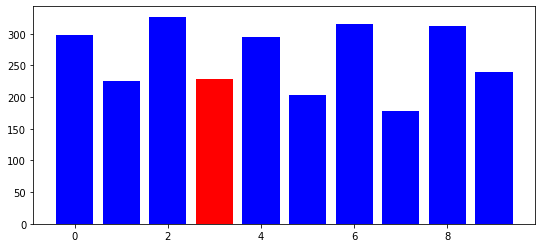

Pictures tested assuming a class 4


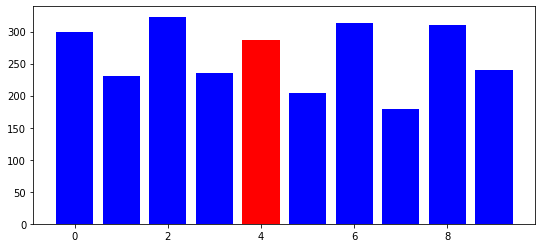

Pictures tested assuming a class 5


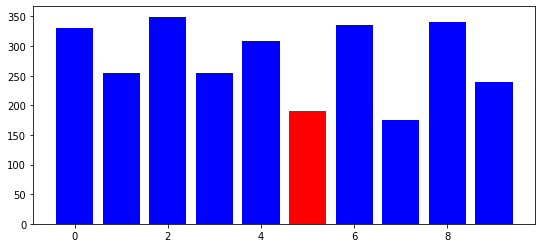

Pictures tested assuming a class 6


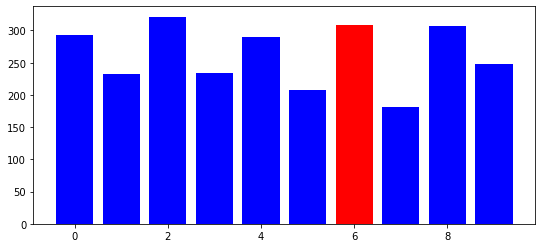

Pictures tested assuming a class 7


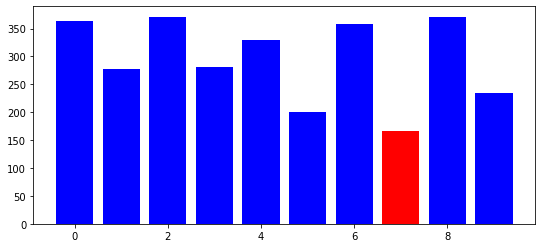

Pictures tested assuming a class 8


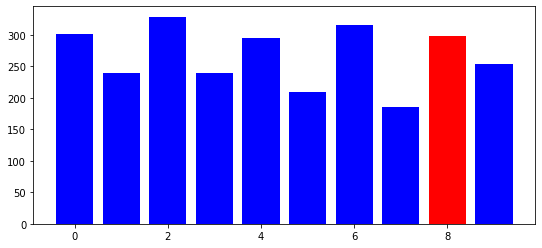

Pictures tested assuming a class 9


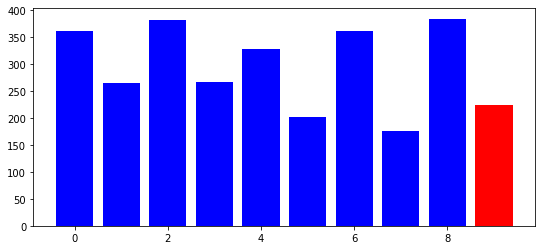

,Tested y=0,Tested y=1,Tested y=2,Tested y=3,Tested y=4,Tested y=5,Tested y=6,Tested y=7,Tested y=8,Tested y=9
Class 0,297.08,304.98,298.02,298.68,299.29,330.02,292.34,362.85,301.93,361.48
Class 1,229.54,221.54,229.80,224.88,230.39,253.81,231.75,277.77,238.90,265.42
Class 2,327.27,330.74,322.91,326.79,323.11,349.52,321.35,371.13,328.85,381.87
Class 3,233.28,234.35,233.38,228.31,236.01,255.17,233.59,280.56,240.25,267.75
Class 4,293.82,295.87,291.01,294.54,287.18,308.41,289.77,329.49,294.38,328.04
Class 5,203.69,204.07,205.41,203.64,204.30,190.26,207.37,200.79,208.92,202.49
Class 6,314.82,319.39,313.03,315.20,313.00,334.70,308.61,358.45,315.98,361.79
Class 7,176.16,177.59,178.91,178.31,178.98,175.91,181.85,166.27,184.90,175.66
Class 8,309.53,315.90,307.55,312.73,309.78,340.16,306.88,370.70,297.44,384.58
Class 9,239.94,240.06,243.35,240.33,239.71,238.51,247.44,235.25,253.00,224.95


In [116]:
table_of_losses = np.zeros([n_classes, n_classes])
for i in range(0,n_classes):
  print('Pictures tested assuming a class {}'.format(i))
  plt.figure(figsize=[9,4])
  for j in range(n_classes):
    testimages = x_test[(y_test==j)]
    testlabels = np.zeros([len(testimages),n_classes]).astype('float32')
    testlabels[:,i] = 1
    testimages = set_pixels_binary(testimages)
    testimages = testimages.reshape(len(testimages), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    loss = -calculate_ELBO(model,testimages, testlabels)
    table_of_losses[j,i] = -loss
    if j==i:
      color='red'
    else:
      color='blue'
    plt.bar(j,-loss.numpy(),color=color)
    y[i]=0
  plt.show()

index = list(str('-') * n_classes)
columns = list(str('-') * (n_classes))
for i in range(n_classes):
    index[i]= 'Class '+ str(i)
    columns[i] = 'Tested y=' + str(i)

table_loss = pd.DataFrame.from_records(np.around(table_of_losses, decimals=2), index=index, columns=columns)
table_loss